In [32]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dhanush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dhanush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/dhanush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sqlalchemy.orm import Session
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.db_utils import DB_ENGINE, Item, Recipe, Restaurant

In [34]:
# with Session(DB_ENGINE) as session:
#     session.query(Recipe).delete()

In [35]:
%time

# Preprocessing function
def preprocess(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    cleaned_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words])
    return cleaned_text

# Get entrees and recipes from the database
with Session(DB_ENGINE) as session:
    entrees = session.query(Item).all()
    recipes = session.query(Recipe).all()
    print(f"Found {len(entrees)} entrees and {len(recipes)} recipes")

# Preprocess entree descriptions and recipe ingredients
entree_descriptions = [preprocess(f"{entree.name} {entree.description}") for entree in entrees]
recipe_ingredients = [preprocess(f"{recipe.name} {recipe.ingredients}") for recipe in recipes]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the preprocessed text
entree_vectors = vectorizer.fit_transform(entree_descriptions)
recipe_vectors = vectorizer.transform(recipe_ingredients)

# Compute cosine similarity
similarity_matrix = cosine_similarity(entree_vectors, recipe_vectors)

# Assign vegetarian-friendly scores
vegetarian_friendly_scores = similarity_matrix.max(axis=1)


# Assign scores to entrees
with Session(DB_ENGINE) as session:
    for idx, entree in enumerate(entrees):
        entree.vegetarian_friendly_score = vegetarian_friendly_scores[idx]
    session.commit()

CPU times: user 0 ns, sys: 1e+03 ns, total: 1e+03 ns
Wall time: 3.58 µs
Found 2034 entrees and 1855 recipes


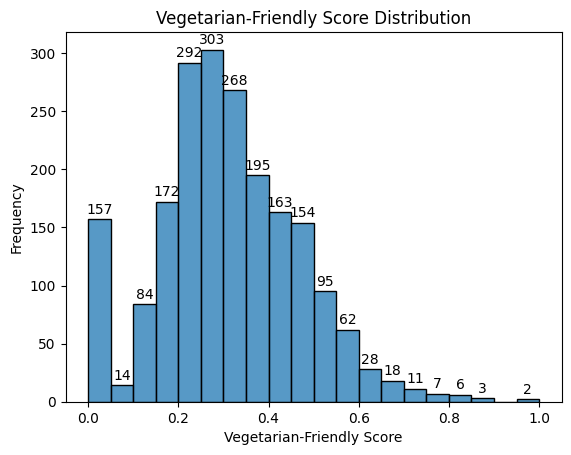

In [36]:
# Create a Seaborn distribution plot
n_bins = 20
hist_plot = sns.histplot(vegetarian_friendly_scores, kde=False, bins=n_bins)

# Set plot title and labels
plt.title('Vegetarian-Friendly Score Distribution')
plt.xlabel('Vegetarian-Friendly Score')
plt.ylabel('Frequency')

bin_heights, bin_edges, _ = hist_plot.hist(vegetarian_friendly_scores, bins=n_bins, alpha=0)
for i in range(n_bins):
    height = bin_heights[i]
    if height > 0:
        hist_plot.annotate(f'{int(height)}', xy=(bin_edges[i]+(bin_edges[i+1]-bin_edges[i])/2, height),
                           xycoords='data', xytext=(0, 2), textcoords='offset points',
                           fontsize=10, ha='center', va='bottom')


# Show the plot
plt.show()

In [37]:
# Print a few item names per bin
n_items_to_print = 3

bins = [[] for _ in range(n_bins)]

# Assign item names to the corresponding bins
for idx, score in enumerate(vegetarian_friendly_scores):
    bin_idx = min(np.digitize(score, bin_edges) - 1, len(bins) - 1)
    bins[bin_idx].append(entrees[idx].name)

# Print a few item names from each bin
for i, bin_items in enumerate(bins):
    print(f"Bin {i + 1} ({bin_edges[i]:.2f} to {bin_edges[i + 1]:.2f}):")
    for item_name in bin_items[:n_items_to_print]:
        print(f"  - {item_name}")
    print()

Bin 1 (0.00 to 0.05):
  - Regular Coffee
  - Decaf Coffee
  - Iced Tea

Bin 2 (0.05 to 0.10):
  - Dirty Matcha Snowbubble (Oreos and Matcha)
  - Dirty Taro Snowbubble (Oreos and Taro)
  - Captain Crunch Snowbubble

Bin 3 (0.10 to 0.15):
  - Fizz
  - Fruit Snowbubble
  - Taro Snowbubble

Bin 4 (0.15 to 0.20):
  - Chicken Jambalaya
  - Fish and Chips
  - Longsilog (Pork longganisa)

Bin 5 (0.20 to 0.25):
  - Magoo's 1/2 lb. Burger
  - Magoo's Special CBB Burger
  - Bacon Cheeseburger

Bin 6 (0.25 to 0.30):
  - Turkey Bacon Melt
  - Tri-Tip Sandwich
  - Impossible Veggie Burger

Bin 7 (0.30 to 0.35):
  - BLT
  - Traditional Club
  - Philly Cheese Steak

Bin 8 (0.35 to 0.40):
  - Chicken Cobb Salad
  - Steak Sandwich
  - Pot Roast

Bin 9 (0.40 to 0.45):
  - Cheese Quesadilla
  - Southwestern Chicken Salad
  - Grilled Ham and Cheese

Bin 10 (0.45 to 0.50):
  - Kale Caesar Salad
  - BBQ Chicken Salad
  - Mediterranean Chicken Salad

Bin 11 (0.50 to 0.55):
  - Swiss Mushroom Burger
  - Chicke

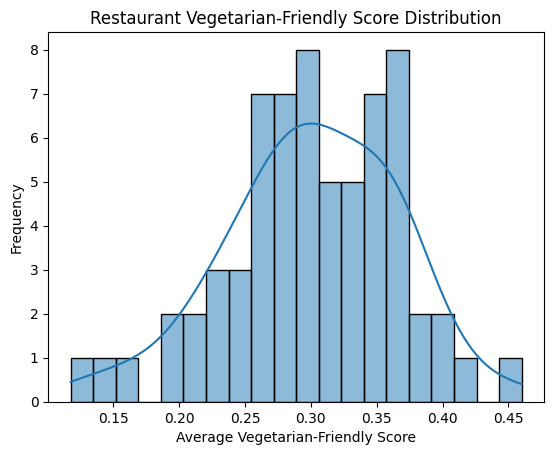

In [38]:
from collections import defaultdict

# Assuming you have a list of entrees with their scores and restaurant IDs
entrees_with_scores = [
    {
        "name": entree.name,
        "restaurant_id": entree.restaurant_id,
        "vegetarian_friendly_score": score
    }
    for entree, score in zip(entrees, vegetarian_friendly_scores)
]

# Calculate the average score for each restaurant
restaurant_scores = defaultdict(lambda: {"count": 0, "total_score": 0})

for entree in entrees_with_scores:
    restaurant_id = entree["restaurant_id"]
    restaurant_scores[restaurant_id]["count"] += 1
    restaurant_scores[restaurant_id]["total_score"] += entree["vegetarian_friendly_score"]

for restaurant_id, data in restaurant_scores.items():
    data["average_score"] = data["total_score"] / data["count"]

# Sort the restaurant scores in descending order
sorted_restaurant_scores = sorted(restaurant_scores.items(), key=lambda x: x[1]['average_score'], reverse=True)

# # Print the sorted scores
# for restaurant_id, data in sorted_restaurant_scores:
#     print(f"Restaurant ID {restaurant_id}: Average Vegetarian-Friendly Score = {data['average_score']:.2f}")

# Create a list of average scores for the histogram
average_scores = [data['average_score'] for _, data in sorted_restaurant_scores]

# Create a histogram of the restaurant score distribution
sns.histplot(average_scores, kde=True, bins=20)

# Set plot title and labels
plt.title('Restaurant Vegetarian-Friendly Score Distribution')
plt.xlabel('Average Vegetarian-Friendly Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [39]:
# Fetch the restaurant names from the database
with Session(DB_ENGINE) as session:
    restaurants = session.query(Restaurant).all()
restaurant_dict = {restaurant.id: restaurant.name for restaurant in restaurants}

# Create a list of average scores for the histogram
average_scores = [data['average_score'] for _, data in sorted_restaurant_scores]

# Assign restaurant names and scores to the corresponding bins
n_bins = 20
n_items_to_print = 3

bins = [[] for _ in range(n_bins)]
bin_edges = np.histogram_bin_edges(average_scores, bins=n_bins)

for restaurant_id, data in sorted_restaurant_scores:
    bin_idx = min(np.digitize(data["average_score"], bin_edges) - 1, len(bins) - 1)
    bins[bin_idx].append((restaurant_dict[restaurant_id], data["average_score"]))

# Print a few restaurant names and scores from each bin
for i, bin_items in enumerate(bins):
    print(f"Bin {i + 1} ({bin_edges[i]:.2f} to {bin_edges[i + 1]:.2f}):")
    for name, score in bin_items[:n_items_to_print]:
        print(f"  - {name} (score: {score:.2f})")
    print()

Bin 1 (0.12 to 0.13):
  - Kusinera (score: 0.12)

Bin 2 (0.13 to 0.15):
  - Philhouse- Hayward (score: 0.15)

Bin 3 (0.15 to 0.17):
  - PhilHouse (score: 0.16)

Bin 4 (0.17 to 0.19):

Bin 5 (0.19 to 0.20):
  - Pressed Acai Bowls (75 First Street) (score: 0.20)
  - Oriental Food Market (score: 0.19)

Bin 6 (0.20 to 0.22):
  - Mama Liang's (score: 0.22)
  - Crave Cafe & Catering (score: 0.21)

Bin 7 (0.22 to 0.24):
  - MIEN TAY RESTAURANT (score: 0.23)
  - The Kebab Shop (Walnut Creek) (score: 0.23)
  - Gyro Station (47 6th Street) (score: 0.22)

Bin 8 (0.24 to 0.25):
  - Ana Rosas Mexican Restaurant (score: 0.25)
  - Los Kuyas (score: 0.24)
  - Mumu l Creative storytelling through food (score: 0.24)

Bin 9 (0.25 to 0.27):
  - Amawele's South African Cuisine (score: 0.27)
  - KRISPY KRUNCHY CHICKEN (2353 East 12th Street) (score: 0.26)
  - Edible Arrangements (1866 S Norfolk St ) (score: 0.26)

Bin 10 (0.27 to 0.29):
  - Red Sea Coral (score: 0.29)
  - Alem's Coffee (score: 0.29)
  - Pop

In [40]:
# Save restaurant scores to the DB
with Session(DB_ENGINE) as session:
    for restaurant_id, data in sorted_restaurant_scores:
        restaurant = session.query(Restaurant).get(restaurant_id)
        restaurant.vegetarian_friendly_score = data["average_score"]
    session.commit()

In [41]:
# Get restaurant scores from the DB and sort by descending score
with Session(DB_ENGINE) as session:
    restaurants = session.query(Restaurant).all()
    sorted_restaurants = sorted(restaurants, key=lambda x: x.vegetarian_friendly_score if x.vegetarian_friendly_score is not None else -1, reverse=True)

# Print the sorted restaurant scores
for restaurant in sorted_restaurants:
    print(f"Restaurant ID {restaurant.id}: {restaurant.name} - Average Vegetarian-Friendly Score = {restaurant.vegetarian_friendly_score}")

Restaurant ID 263: Brioche de Paris - Average Vegetarian-Friendly Score = 0.4600636068510689
Restaurant ID 209: Kolobok (the only Russian food truck in the Bay Area) - Average Vegetarian-Friendly Score = 0.42116356435668895
Restaurant ID 291: Crawstation - Average Vegetarian-Friendly Score = 0.4007484478043439
Restaurant ID 424: Champagne Restaurant - Average Vegetarian-Friendly Score = 0.395169644600234
Restaurant ID 415: 77 Chinese & Vietnamese Cuisine - Average Vegetarian-Friendly Score = 0.38452138192751856
Restaurant ID 125: Fusion SF - Average Vegetarian-Friendly Score = 0.37811603098500896
Restaurant ID 68: Brasil Bistro - Average Vegetarian-Friendly Score = 0.3730321789179806
Restaurant ID 98: Amsterdam Cafe - Average Vegetarian-Friendly Score = 0.3678065259787852
Restaurant ID 89: Pizza Matador - Average Vegetarian-Friendly Score = 0.365912645703404
Restaurant ID 164: Halal Grill - Average Vegetarian-Friendly Score = 0.36588992825907696
Restaurant ID 165: Halal 786 Degrees - A